In [1]:
%matplotlib inline

In [96]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import nltk
from collections import defaultdict
import re
import torch.utils.data as data
import sys
import os

from gensim import utils

Using TensorFlow backend.


In [3]:
home_directory = os.path.expanduser('~')
nn_library_path = home_directory + '/Documents/Programming/Neural Nets Library'
sys.path.append(nn_library_path)

In [4]:
import training

In [71]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(CBOW, self).__init__()
        
        self.embeddings = nn.EmbeddingBag(vocab_size, hidden_size)
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x):
        context_vector = self.embeddings(x)
        hidden_values = self.softmax_layer(context_vector)
        
        return hidden_values
    
    def lookup(self, word, word_dictionary):
        word_id = word_dictionary[word]
        start_vec = Variable(torch.LongTensor([word_id]).unsqueeze(0)).cuda()
        
        return self.embeddings(start_vec)[0]

In [97]:
def get_frequencies(ls):
    frequencies = defaultdict(int)
    
    for word in ls:
        frequencies[word] += 1
    
    return frequencies

def filter_corpus(text, minimum_frequency=10):
    words = list(map(lambda word: word.lower(), filter(lambda word: re.match('[A-Za-z]', word) is not None, text)))
    frequencies = get_frequencies(words)
    
    return list(filter(lambda word: frequencies[word] >= minimum_frequency, words))

def make_word_dictionary(text):
    word_dictionary = {}
    word_index = 0
    
    for word in text:
        if word not in word_dictionary:
            word_dictionary[word] = word_index
            word_index += 1
    
    return word_dictionary

In [7]:
class CBOWDataset(data.Dataset):
    def __init__(self, text, context_size, word_dictionary):
        self.word_dictionary = word_dictionary
        self.context_size = context_size
        self.word_indices = torch.LongTensor(list(map(lambda word: word_dictionary[word], text)))
        
    def __len__(self):
        return len(self.word_indices) - 2*self.context_size
    
    def __getitem__(self, index):
        prior_words = self.word_indices[index:index+context_size]
        later_words = self.word_indices[index+context_size+1:index+2*context_size+1]
        
        return torch.cat((prior_words, later_words)), self.word_indices[index+context_size]

In [8]:
penn_treebank_text = nltk.corpus.treebank.words()
training_corpus = filter_corpus(penn_treebank_text)
word_dictionary = make_word_dictionary(training_corpus)
context_size = 4
vocab_size = len(word_dictionary)

dataset = CBOWDataset(training_corpus, context_size, word_dictionary)

In [9]:
id_to_word = []
id_to_word_dict = {}

for word, id_value in word_dictionary.items():
    id_to_word_dict[id_value] = word

for i in range(len(id_to_word_dict)):
    id_to_word.append(id_to_word_dict[i])

In [88]:
word2vec_model = nn.DataParallel(CBOW(vocab_size, 200).cuda())
data_loader = data.DataLoader(dataset, batch_size = 256, shuffle = True, num_workers = 4, pin_memory = True)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(word2vec_model.parameters(), lr = 0.001, momentum = 0.9)

In [95]:
word2vec_model, losses = training.train_model(word2vec_model, data_loader, criterion, optimizer, num_epochs = 20)

Epoch 0/199
----------
LR is set to 0.001
Epoch Number: 0, Batch Number: 200, Loss: 0.0255
Time so far is 0m 1s

Epoch 1/199
----------
Epoch Number: 1, Batch Number: 176, Loss: 0.0255
Time so far is 0m 2s

Epoch 2/199
----------
Epoch Number: 2, Batch Number: 152, Loss: 0.0255
Time so far is 0m 3s

Epoch 3/199
----------
Epoch Number: 3, Batch Number: 128, Loss: 0.0255
Time so far is 0m 4s

Epoch 4/199
----------
Epoch Number: 4, Batch Number: 104, Loss: 0.0255
Time so far is 0m 5s

Epoch 5/199
----------
Epoch Number: 5, Batch Number: 80, Loss: 0.0255
Time so far is 0m 6s

Epoch 6/199
----------
Epoch Number: 6, Batch Number: 56, Loss: 0.0255
Time so far is 0m 7s

Epoch 7/199
----------
LR is set to 0.0001
Epoch Number: 7, Batch Number: 32, Loss: 0.0255
Time so far is 0m 7s

Epoch 8/199
----------
Epoch Number: 8, Batch Number: 8, Loss: 0.0254
Time so far is 0m 8s
Epoch Number: 8, Batch Number: 208, Loss: 0.0255
Time so far is 0m 9s

Epoch 9/199
----------
Epoch Number: 9, Batch Numb

Epoch Number: 75, Batch Number: 200, Loss: 0.0255
Time so far is 1m 8s

Epoch 76/199
----------
Epoch Number: 76, Batch Number: 176, Loss: 0.0255
Time so far is 1m 9s

Epoch 77/199
----------
LR is set to 1.0000000000000006e-14
Epoch Number: 77, Batch Number: 152, Loss: 0.0256
Time so far is 1m 10s

Epoch 78/199
----------
Epoch Number: 78, Batch Number: 128, Loss: 0.0255
Time so far is 1m 11s

Epoch 79/199
----------
Epoch Number: 79, Batch Number: 104, Loss: 0.0255
Time so far is 1m 11s

Epoch 80/199
----------
Epoch Number: 80, Batch Number: 80, Loss: 0.0255
Time so far is 1m 12s

Epoch 81/199
----------
Epoch Number: 81, Batch Number: 56, Loss: 0.0255
Time so far is 1m 13s

Epoch 82/199
----------
Epoch Number: 82, Batch Number: 32, Loss: 0.0255
Time so far is 1m 14s

Epoch 83/199
----------
Epoch Number: 83, Batch Number: 8, Loss: 0.0255
Time so far is 1m 15s
Epoch Number: 83, Batch Number: 208, Loss: 0.0255
Time so far is 1m 15s

Epoch 84/199
----------
LR is set to 1.00000000000

Epoch Number: 149, Batch Number: 24, Loss: 0.0255
Time so far is 2m 11s
Epoch Number: 149, Batch Number: 224, Loss: 0.0255
Time so far is 2m 11s

Epoch 150/199
----------
Epoch Number: 150, Batch Number: 200, Loss: 0.0255
Time so far is 2m 12s

Epoch 151/199
----------
Epoch Number: 151, Batch Number: 176, Loss: 0.0255
Time so far is 2m 13s

Epoch 152/199
----------
Epoch Number: 152, Batch Number: 152, Loss: 0.0255
Time so far is 2m 14s

Epoch 153/199
----------
Epoch Number: 153, Batch Number: 128, Loss: 0.0255
Time so far is 2m 14s

Epoch 154/199
----------
LR is set to 1.0000000000000013e-25
Epoch Number: 154, Batch Number: 104, Loss: 0.0255
Time so far is 2m 15s

Epoch 155/199
----------
Epoch Number: 155, Batch Number: 80, Loss: 0.0255
Time so far is 2m 16s

Epoch 156/199
----------
Epoch Number: 156, Batch Number: 56, Loss: 0.0255
Time so far is 2m 17s

Epoch 157/199
----------
Epoch Number: 157, Batch Number: 32, Loss: 0.0256
Time so far is 2m 18s

Epoch 158/199
----------
Epoc

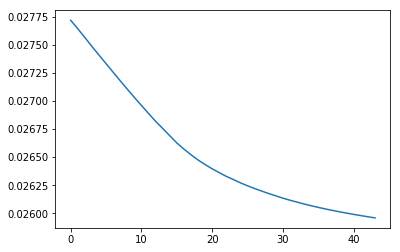

In [92]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(losses)

In [ ]:
def most_similar(model, positive=[], negative=[], topn=10):
    """
    Find the top-N most similar words. Positive words contribute positively towards the
    similarity, negative words negatively.
    `model.word_vectors` must be a matrix of word embeddings (already L2-normalized),
    and its format must be either 2d numpy (dense) or scipy.sparse.csr.
    """
    if isinstance(positive, basestring) and not negative:
        # allow calls like most_similar('dog'), as a shorthand for most_similar(['dog'])
        positive = [positive]

    # add weights for each word, if not already present; default to 1.0 for positive and -1.0 for negative words
    positive = [
        (word, 1.0) if isinstance(word, (basestring, numpy.ndarray)) else word
        for word in positive]
    negative = [
        (word, -1.0) if isinstance(word, (basestring, numpy.ndarray)) else word
        for word in negative]

    # compute the weighted average of all words
    all_words, mean = set(), []
    for word, weight in positive + negative:
        if isinstance(word, numpy.ndarray):
            mean.append(weight * word)
        elif word in model.word2id:
            word_index = model.word2id[word]
            mean.append(weight * model.word_vectors[word_index])
            all_words.add(word_index)
        else:
            raise KeyError("word '%s' not in vocabulary" % word)
    if not mean:
        raise ValueError("cannot compute similarity with no input")
    if scipy.sparse.issparse(model.word_vectors):
        mean = scipy.sparse.vstack(mean)
    else:
        mean = numpy.array(mean)
    mean = matutils.unitvec(mean.mean(axis=0)).astype(model.word_vectors.dtype)

    dists = model.word_vectors.dot(mean.T).flatten()
    if not topn:
        return dists
    best = numpy.argsort(dists)[::-1][:topn + len(all_words)]

    # ignore (don't return) words from the input
    result = [(model.id2word[sim], float(dists[sim])) for sim in best if sim not in all_words]

    return result[:topn]

def log_accuracy(section):
    correct, incorrect = section['correct'], section['incorrect']
    if correct + incorrect > 0:
        print("%s: %.1f%% (%i/%i)" %
            (section['section'], 100.0 * correct / (correct + incorrect),
            correct, correct + incorrect))

def accuracy(model, questions, ok_words, word_dictionary):
    """
    Compute accuracy of the word embeddings.
    `questions` is a filename where lines are 4-tuples of words, split into
    sections by ": SECTION NAME" lines.
    See https://code.google.com/p/word2vec/source/browse/trunk/questions-words.txt for an example.
    The accuracy is reported (=printed to log and returned as a list) for each
    section separately, plus there's one aggregate summary at the end.
    Only evaluate on words in `word2id` (such as 30k most common words), ignoring
    any test examples where any of the four words falls outside `word2id`.
    This method corresponds to the `compute-accuracy` script of the original C word2vec.
    """

    sections, section = [], None
    for line_no, line in enumerate(utils.smart_open(questions)):
        line = utils.to_unicode(line)
        if line.startswith(': '):
            # a new section starts => store the old section
            if section:
                sections.append(section)
                log_accuracy(section)
            section = {'section': line.lstrip(': ').strip(), 'correct': 0, 'incorrect': 0}
        else:
            if not section:
                raise ValueError("missing section header before line #%i in %s" % (line_no, questions))
            try:
                a, b, c, expected = [word.lower() for word in line.split()] 
            except:
                print("skipping invalid line #%i in %s" % (line_no, questions))
            if a not in ok_words or b not in ok_words or c not in ok_words or expected not in ok_words:
                print("skipping line #%i with OOV words: %s" % (line_no, line.strip()))
                continue

            ignore = set(word_dictionary[v] for v in [a, b, c])  # indexes of words to ignore
            predicted = None

            # find the most likely prediction, ignoring OOV words and input words
            sims = most_similar(model, positive=[b, c], negative=[a], topn=False)
            for index in numpy.argsort(sims)[::-1]:
                if model.id2word[index] in ok_words and index not in ignore:
                    predicted = model.id2word[index]
                    if predicted != expected:
                        logger.debug("%s: expected %s, predicted %s" % (line.strip(), expected, predicted))
                    break

            section['correct' if predicted == expected else 'incorrect'] += 1
    if section:
        # store the last section, too
        sections.append(section)
        log_accuracy(section)

    total = {'section': 'total', 'correct': sum(s['correct'] for s in sections), 'incorrect': sum(s['incorrect'] for s in sections)}
    log_accuracy(total)
    sections.append(total)
    return sections

In [75]:
word2vec_model.module.lookup('man', word_dictionary)

Variable containing:
 1.2996
-0.5917
 0.1506
-0.7426
-1.6214
-0.4217
 0.4004
 0.1098
 1.1753
-0.5553
-0.7912
 1.5314
 0.6268
 2.3838
-0.9732
-0.8033
-0.1535
-0.9036
-0.3500
 0.9619
-1.5441
 0.4123
 0.3171
 0.2561
-0.0216
 0.1781
 0.0233
-0.5583
-0.1787
 1.8202
 0.1236
-0.3718
 1.3955
 2.0521
-1.2064
-2.5305
 0.3084
-0.3150
 0.3582
-1.5001
-0.2157
-0.3455
-0.2168
-0.0532
 1.8616
-0.6592
 0.3282
-0.4089
 0.5479
 0.0725
-1.6682
-2.2214
-0.5638
-1.5363
 1.6185
 0.1768
-1.2364
-1.1346
-0.5710
 0.4065
-1.1067
-0.2257
 0.5945
-2.7637
 0.6140
-0.6395
 0.4668
-1.2638
 0.4237
 0.7419
-1.3740
 1.3386
-0.5660
 0.0170
 0.1355
-1.5914
-0.0297
 0.9536
-1.0453
-0.5211
 0.8433
-0.8491
 0.2185
 0.7313
 1.1205
 0.1938
-0.1025
-0.0094
-0.4112
-0.1801
-1.2364
-0.9337
-2.3567
-1.0634
 0.4226
-0.4526
-2.3171
 2.0197
-0.5446
-0.4111
-0.2156
-0.0309
 0.0095
 1.6864
-0.4980
-1.2551
 0.8065
-1.2130
-0.8944
 0.9086
 0.5113
 0.4413
 0.3812
 0.4418
-0.7326
 2.0286
 1.3737
 1.9850
-1.7395
 1.0533
 0.0176
 1.0853
-2.